In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '32'
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import math
import sys
sys.path.append('../')
from pyfd3d import pyfd3d
from pyMKL import pardisoSolver


In [2]:
L0 = 1e-6;  #length unit: microns
wvlen = 0.25;  # wavelength in L0


Npml = 1*np.array([10,10,10]);  # [Nx_pml Ny_pml]
xrange = 0.5*np.array([-1, 1]);  # x boundaries in L0
yrange = 0.5*np.array([-1, 1]);  # y boundaries in L0
zrange = 0.5*np.array([-1, 1]);
N = np.array([61,61,61])

In [3]:
## create domain with pml


In [4]:
## Set up the permittivity.
eps_r = np.ones(N)
print(eps_r.shape)
M = np.prod(N)
print(M)


(61, 61, 61)
226981


In [5]:
## Set up the current source density.
Jz = np.zeros(N);
print(np.floor(N/2).astype('int'), N)
ind_src = (np.floor(N/2).astype('int'));  # (i,j) indices of the center cell; Nx, Ny should be odd
Jz[ind_src[0], ind_src[1], ind_src[2]] = 1;
Jx = np.zeros(N);
Jy = np.zeros(N);
eps_r_tensor_dict = {
    'eps_xx': eps_r,
    'eps_yy': eps_r,
    'eps_zz': eps_r,
}
JCurrentVector = {
    'Jx': Jx,
    'Jy': Jy,
    'Jz': Jz
}

[30 30 30] [61 61 61]


In [6]:
## Wonsoek's scalar parameter 1, -1, or 0
s = -1;

In [7]:
dir(pyfd3d)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [8]:
import pyfd3d.fd3d as fd3d

In [9]:
print(wvlen)

0.25


In [10]:
A,b, Ch = fd3d.curlcurlE(L0, wvlen, xrange, yrange, zrange, eps_r_tensor_dict, JCurrentVector,Npml)

(680943,)


  (0, 61)	(8978636080071.443-998881070360.5681j)
  (0, 0)	(-574962699677459.8+10026718164764.01j)
  (0, 60)	(8978636080071.443-998881070360.5681j)
  (0, 1)	(11914019243891.205-1531079626681.1138j)
  (1, 62)	(8978636080071.443-998881070360.5681j)
  (1, 1)	(-591922733299990.2+13727248165585.652j)
  (1, 2)	(21835680994491.266-3834616173614.023j)
  (1, 0)	(16017007952001.787-2395874524249.302j)
  (2, 63)	(8978636080071.443-998881070360.5681j)
  (2, 2)	(-626716634972663.9+24382099089635.125j)
  (2, 3)	(42436505925735-10595476546971.7j)
  (2, 1)	(30210084693431.68-6289865074941.095j)
  (3, 64)	(8978636080071.443-998881070360.5681j)
  (3, 3)	(-702013831718196+58667300461474.51j)
  (3, 4)	(87433575419924.47-32804807209001.637j)
  (3, 2)	(60510211944774.39-18365735784750.543j)
  (4, 65)	(8978636080071.443-998881070360.5681j)
  (4, 4)	(-866689715824961.5+182159540035852.7j)
  (4, 5)	(185203447912065.06-114271033138896.5j)
  (4, 3)	(127416223559399.3-60391749429233.87j)
  (5, 66)	(8978636080071.4

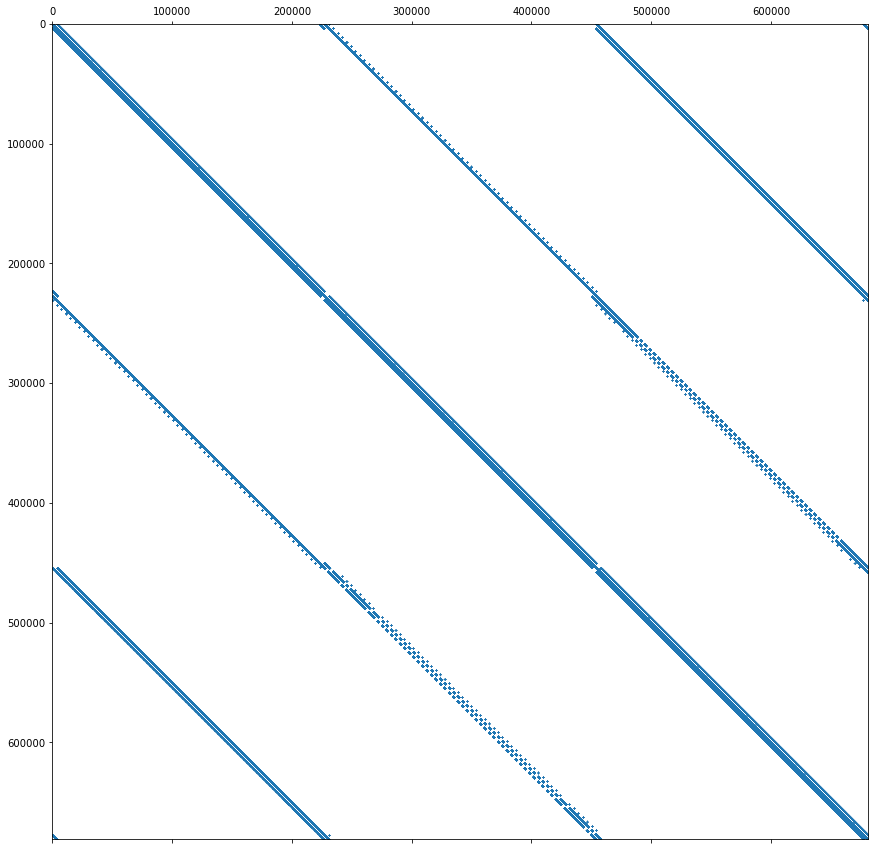

In [11]:
plt.figure(figsize = (15,15))
plt.spy(A, markersize = 0.2)
print(A[0:100, 0:100])

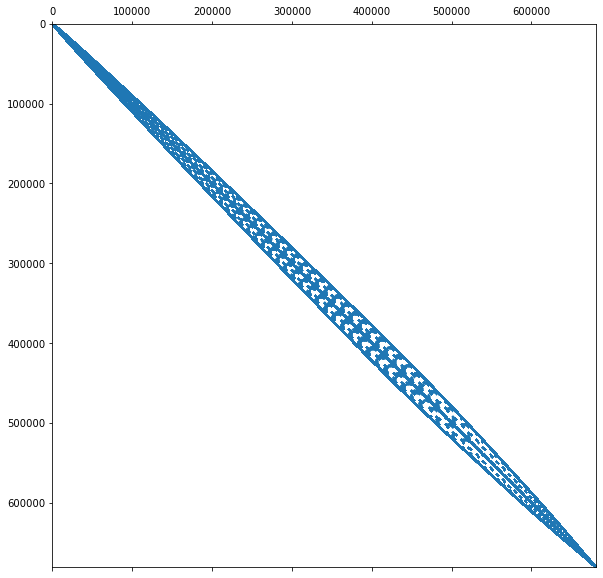

In [12]:
from scipy.sparse.csgraph import reverse_cuthill_mckee

prcm = reverse_cuthill_mckee(A)
row = np.arange(3*M)
col = prcm
P = sp.coo_matrix((np.ones(3*M), (row, col)), shape=(3*M,3*M))
plt.figure(figsize = (10,10))
plt.spy(P@A@P.T, markersize = 0.5)

## utilize iterative solver

In [13]:
from scipy.sparse.linalg import qmr, bicgstab

In [40]:
%%time
#x, info = qmr(A, b, maxiter = 2000)
xsoln, info = bicgstab(A,b, maxiter = 2000);

CPU times: user 1min 16s, sys: 807 ms, total: 1min 17s
Wall time: 9.7 s


0


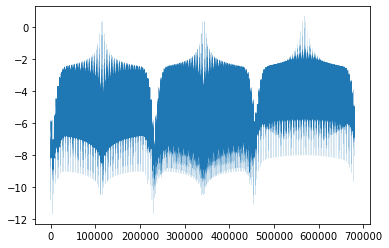

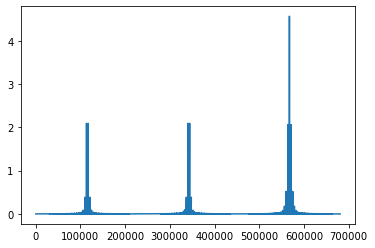

In [41]:
print(info)
plt.figure();
plt.plot(np.log10(np.abs(xsoln)), linewidth = 0.1)
plt.figure()
plt.plot(np.abs(xsoln))

/var/folders/f8/nqg1jnk548j7c367bl0lgl0r0000gn/T/ipykernel_95243/525207952.py:7: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



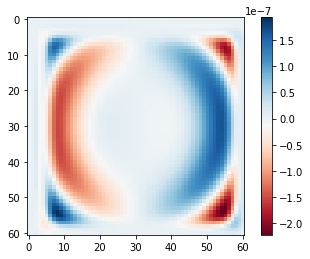

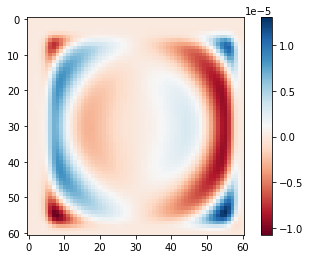

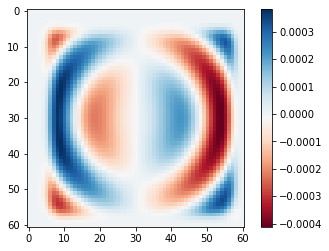

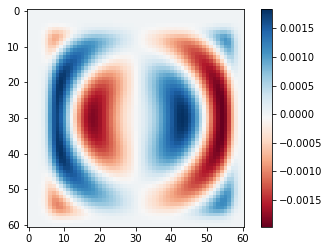

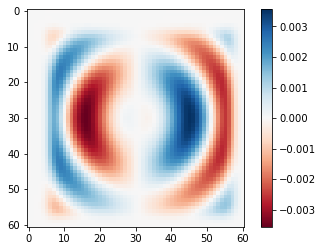

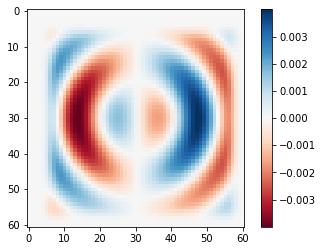

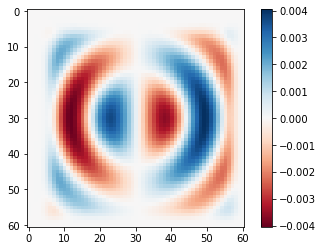

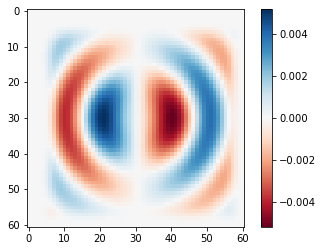

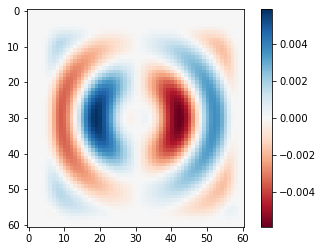

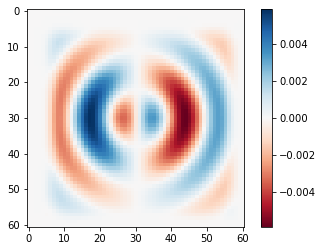

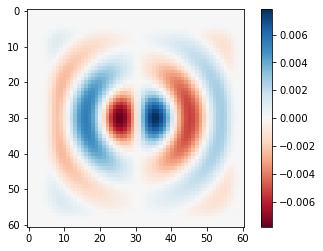

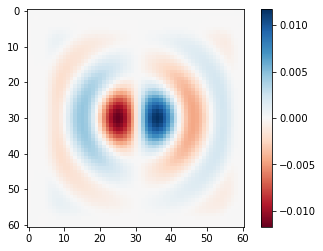

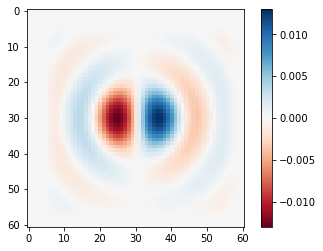

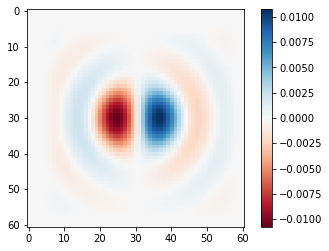

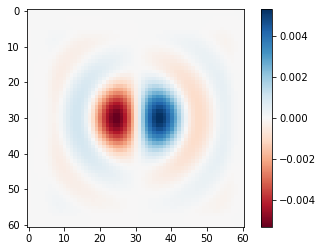

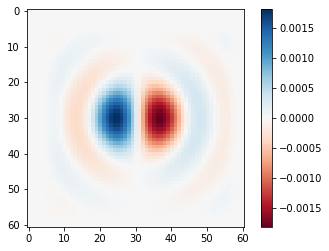

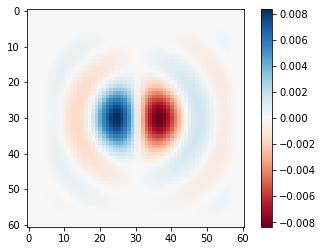

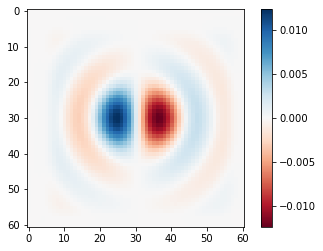

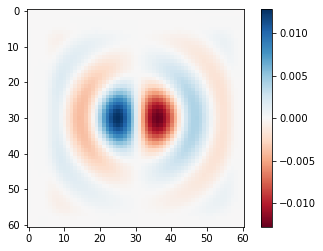

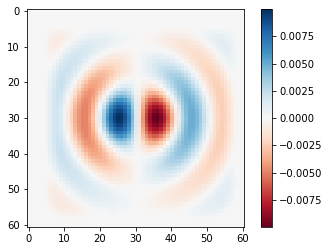

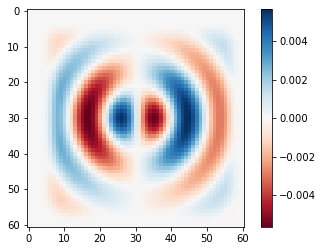

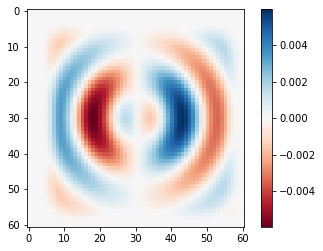

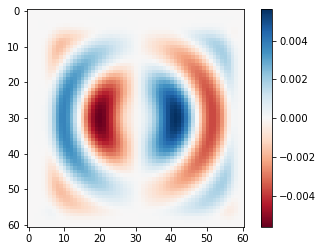

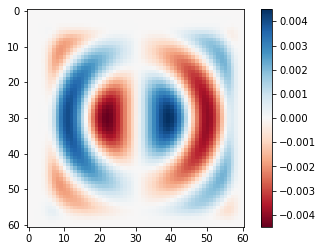

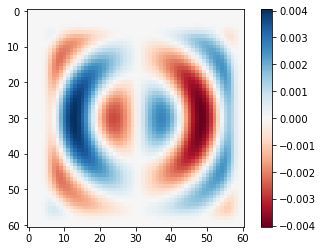

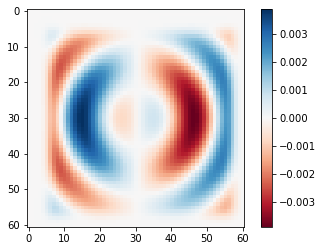

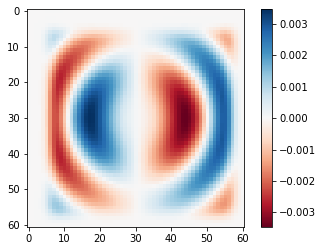

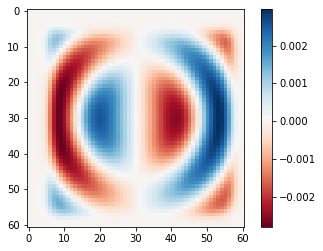

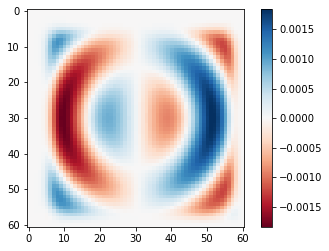

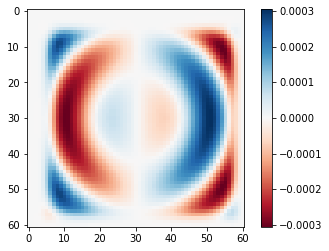

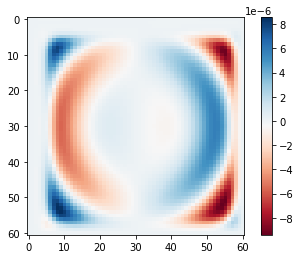

In [44]:
# flipped Ez looks like Ey, Ey looks like Ex, Ex looks like Ez
Ex = xsoln[0:M].reshape(N, order = 'F');
Ey = xsoln[M:2*M].reshape(N, order = 'F')
Ez = xsoln[2*M:].reshape(N, order = 'F')

for i in range(0,N[0],2):
    plt.figure()
    plt.imshow(np.real(Ey[:,i,:]), cmap = 'RdBu')
    #plt.clim(0,0.5e-2)
    plt.colorbar()



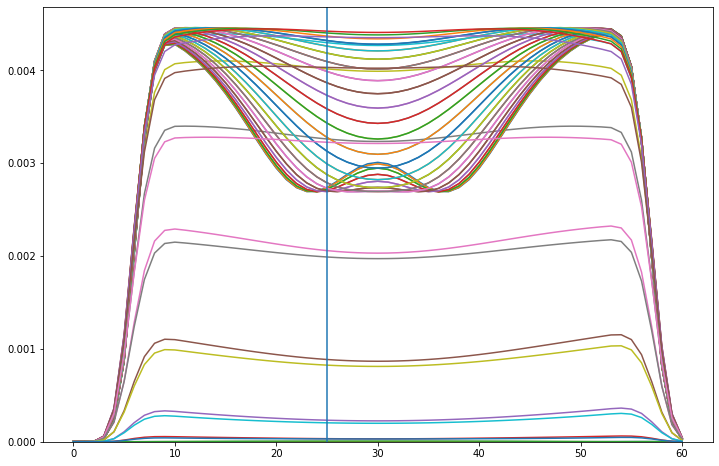

In [45]:

plt.figure(figsize = (12,8));
for i in range(N[0]):
    plt.plot(np.abs(Ez[i,:,12]))
plt.axvline(25)
plt.ylim(ymin = 0)
plt.show()

In [47]:
print(A.shape)

print(np.linalg.norm(A@xsoln-b)/np.linalg.norm(b))
print(np.allclose(A.dot(xsoln), b))

(680943, 680943)
8.7852542278851e-06
False


## WARNING: careful with direct solvers

In [19]:
#try solving with pardiso
# pardiso doesn't even really work with this FDFD matrix, which is odd...honestly very very odd

## for vaccum, mtype=13, complex, non-symmetric
# mtype=6 is complex symmetric
pSolve = pardisoSolver(A, mtype=6)



In [20]:
A.shape
print(A.count_nonzero())

6899649


In [ ]:
%%time
#pSolve.factor()

In [ ]:
#print(pSolve.iparm)

In [ ]:
# use unsymmetric case
#pSolve = pardisoSolver(A, mtype=13)

In [ ]:
%%time
#pSolve.factor()


In [ ]:
print(pSolve.iparm)

In [ ]:
# x0 = pSolve.solve(np.imag(b))
# plt.plot(np.abs(x0))
# plt.figure()
# Ex = np.reshape(x0[0:M],N)

# plt.imshow(np.abs(Ex[:,:,0]))

In [ ]:
# plt.figure(figsize = (10,5))
# plt.plot(np.abs(x0))
# plt.plot(np.abs(x), 'x-', markersize = 1, alpha = 0.2)

## 3D visualization with PLOTLY

In [33]:

from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly.graph_objs import *

def get_the_slice(x,y,z, surfacecolor):
    return go.Surface(x=x,
                      y=y,
                      z=z,
                      surfacecolor=surfacecolor,
                      coloraxis='coloraxis')
def get_lims_colors(surfacecolor):# color limits for a slice
    return np.min(surfacecolor), np.max(surfacecolor)

-0.16666666666666669

In [36]:
Nx,Ny,Nz = N
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2, y=2, z=1)
)

In [69]:
x = np.linspace(xrange[0], xrange[1], Nx)
y = np.linspace(yrange[0], yrange[1], Ny)
z = np.linspace(zrange[0], zrange[1], Nz)

yy,zz, = np.meshgrid(y,z, indexing = 'ij');
xx = x[20] * np.ones(yy.shape)

surfcolor_y = (np.real(Ey[:,20,:]))
surfcolor_z = (np.real(Ey[20,:,:]))
surfcolor_x = (np.real(Ey[:,:,20]))

slice_y = get_the_slice(xx,yy,zz, surfcolor_y)
slice_y.update(cmin=0, cmax=0.2e-2)


xx,zz, = np.meshgrid(y,z, indexing = 'ij');
yy = y[20] * np.ones(yy.shape)
slice_z = get_the_slice(xx,yy,zz, surfcolor_z)
slice_z.update(cmin=0, cmax=0.2e-2)


xx,yy, = np.meshgrid(x,y, indexing = 'ij');
zz = z[20] * np.ones(zz.shape)
slice_x = get_the_slice(xx,yy,zz, surfcolor_x)
slice_x.update(cmin=0, cmax=0.2e-2)


axis = dict(gridcolor="white",
            showbackground=False,
            linecolor="black",
            mirror = True, 
            showline = True)

layout = go.Layout(
         width=700,
         height=700,
         scene=dict(yaxis=axis,
                    xaxis=dict(axis, range = xrange),
                    zaxis=dict(axis, range = zrange),
                    aspectratio=dict(x=1, y=1, z=1)
                    ),
         scene_camera = camera
        )
fig_data = [slice_y, slice_z, slice_x]

fig = go.Figure(data=fig_data, layout=layout)
fig.write_image('../img/vacuum_slices.png')
fig.show();